## What is GAN?
- 생성적 적대 신경망 (Generative Adversarial Networks, GANs)은 요즘 컴퓨터 과학에서 가장 흥미로운 아이디어 중 하나입니다. 두개의 모델이 적대적인 과정을 통해 동시에 훈련됩니다. 생성자 ("예술가")는 진짜처럼 보이는 이미지를 생성하도록 배우는 와중에, 감별자 ("예술비평가")는 가짜의 이미지로부터 진짜를 구별하게 되는 것을 배우게 됩니다.
- 훈련과정 동안 생성자는 점차 실제같은 이미지를 더 잘 생성하게 되고, 감별자는 점차 진짜와 가짜를 더 잘 구별하게됩니다. 이 과정은 감별자가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달하게 됩니다.

In [1]:
import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

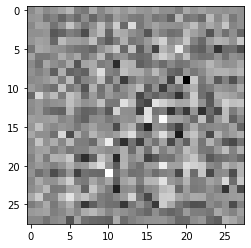

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0031235]], shape=(1, 1), dtype=float32)


In [11]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

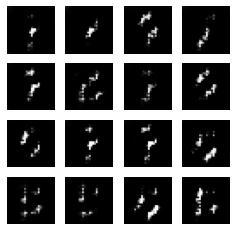

Time for epoch 3 is 30.118624210357666 sec


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\a\anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1313, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 1, in <module>
  File "<ipython-input-17-0545bcac9c3d>", line 6, in train
    train_step(image_batch)
  File "C:\Users\a\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\a\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "C:\Users\a\anaconda3\lib\site-packages\tensorflow\python\eager\function.py", line 2942, in __call__
    return graph_function._call_flat(
  File "C:\Users\a\anaconda3\lib\site-packages\tensorflow\python\eager\function.py", line 1918, in _call_flat
    return self._build_call_outputs(self._inference_function.call(
  File "C:\Users\a\anaconda3\lib\site-p

TypeError: object of type 'NoneType' has no len()

In [19]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [22]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from IPython.display import display
import PIL

In [23]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16730259599603935170
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5060693856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18433747237841370559
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [24]:
from keras import backend as K

K.tensorflow_backend._get_available_gpus()

ModuleNotFoundError: No module named 'keras'